# Train and test AVIDNet

In [1]:
import torch
from torch.utils.data import DataLoader
import os
from torchsummary import summary
from collections import defaultdict
from datasets.transforms import get_data_transforms
from datasets.utils import separate_datasets, show_samples,CovidDataLoader
from models.model import get_model
from models.train import train_model
from models.metrics import update_mean_metrics, print_metrics
from models.utils import set_random_seed

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
random_seed = 0
set_random_seed(random_seed)

## Load data

In [5]:
cfg = {
    'purpose' : 'fixmatch',
    'data_dir' : './data/CXR/ori',
    'num_labeled': 25, #<- 코드 이름이 맞추기
    'mu' : 4,
    'fold' : 5,
    'epochs' : 20,
    'metric_types' : ['acc', 'ppv', 'recall', 'f1']
}
dataset_types = ['train', 'test']

if not os.path.exists(os.path.join(cfg['data_dir'],'test.txt')):
    from datasets.utils import make_baseline_dataset
    make_baseline_dataset(cfg['data_dir'], cfg['num_labeled'], outpath=cfg['data_dir']) # test는 전부, train은 25개 만큼만
    
if cfg['purpose'] == 'fixmatch' and not os.path.exists(os.path.join(cfg['data_dir'],'train_lb_0.txt')):
    from datasets.utils import separate_datasets
    separate_datasets(cfg['data_dir'], cfg['fold'], cfg['epochs'], cfg['mu'],outpath = cfg['data_dir']) # lb는 25개, ulb는 mu*25개     

"train_lb_0.txt" created in ./data/CXR/ori
"train_ulb_0.txt" created in ./data/CXR/ori
"train_lb_1.txt" created in ./data/CXR/ori
"train_ulb_1.txt" created in ./data/CXR/ori
"train_lb_2.txt" created in ./data/CXR/ori
"train_ulb_2.txt" created in ./data/CXR/ori
"train_lb_3.txt" created in ./data/CXR/ori
"train_ulb_3.txt" created in ./data/CXR/ori
"train_lb_4.txt" created in ./data/CXR/ori
"train_ulb_4.txt" created in ./data/CXR/ori


In [6]:
sample_loader = CovidDataLoader('train', cfg, fold_id=0)
class_names = sample_loader.class_names

sample_loader = DataLoader(sample_loader, batch_size=1, num_workers=4, shuffle=True,
                           collate_fn=sample_loader.collate_fn)

In [7]:
class_names

{0: 'covid-19', 1: 'pneumonia', 2: 'normal'}

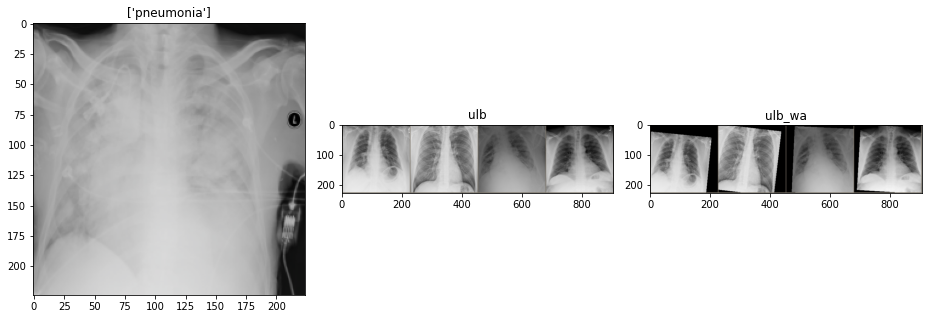

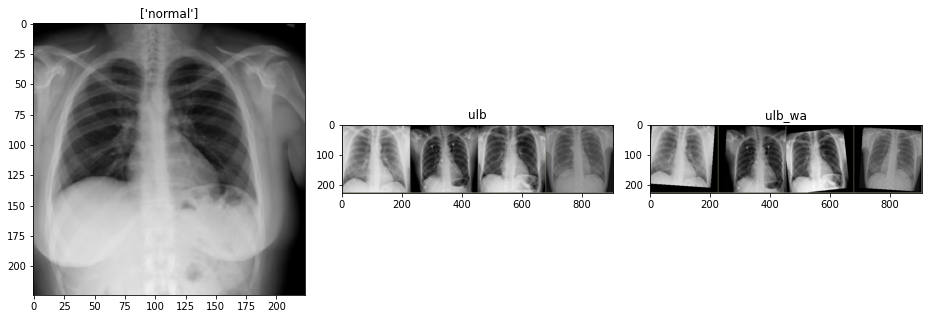

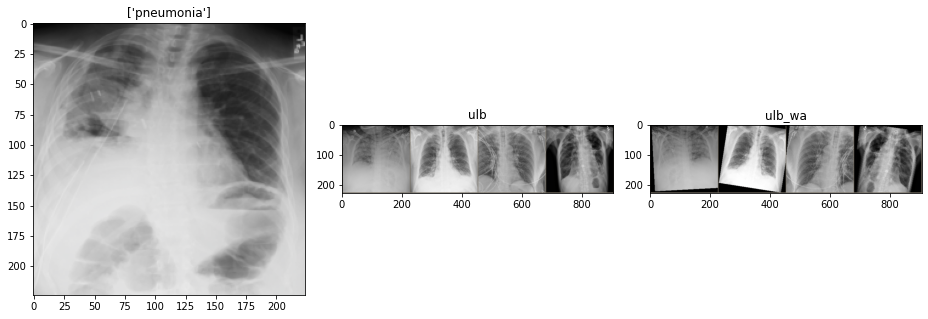

In [8]:
show_iteration = 3
show_samples(sample_loader, class_names, show_iteration, cfg['mu'])

## Train the model

In [13]:
trained_models = []

mean_metrics = {m_type: defaultdict(float) for m_type in cfg['metric_types']}
test_loader = CovidDataLoader('test', cfg)
dataset_sizes ={'test':len(test_loader)}
class_names = list(test_loader.class_names.values())
metric_targets = ['all'] + class_names

test_loader = DataLoader(test_loader, batch_size=6, num_workers=4, shuffle=True,
                              collate_fn=test_loader.collate_fn)
data_loaders ={'test':test_loader}


for i in range(cfg['fold']):
    train_loaders = CovidDataLoader('train', cfg, fold_id=i)
    dataset_sizes['train']=len(train_loaders)
    train_loaders = DataLoader(train_loaders, batch_size=6, num_workers=4, shuffle=True,
                              collate_fn=train_loaders.collate_fn)
    data_loaders['train']=train_loaders

    model_ft, criterion, optimizer_ft, exp_lr_scheduler = get_model(device, fine_tuning=False)
    model, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, i, class_names, metric_targets,
                                 cfg['metric_types'], dataset_types, data_loaders, dataset_sizes, device, num_epochs=20,
                                 lambda_u=1.0, threshold=0.95, purpose=cfg['purpose'], is_early=False)
    trained_models.append(model)
    mean_metrics = update_mean_metrics(metric_targets, mean_metrics, metrics, status='training')

mean_metrics = update_mean_metrics(metric_targets, mean_metrics, status='final', fold=cfg['fold'])
print_metrics(mean_metrics, metric_targets, phase='Mean results')

--------------------
Model 1
--------------------

Epoch 0/19
----------
[train]
LOSS - 1.1012
ACC - 0.4000
PPV - ALL: 0.3830  COVID-19: 0.3158  PNEUMONIA: 0.5000  NORMAL: 0.3333 
RECALL - ALL: 0.4000  COVID-19: 0.3000  PNEUMONIA: 0.6500  NORMAL: 0.2500 
F1 - ALL: 0.3862  COVID-19: 0.3077  PNEUMONIA: 0.5652  NORMAL: 0.2857 
Mask ratio's range: 1.0 ~ 1.0

[test]
LOSS - 1.0498
ACC - 0.4009
PPV - ALL: 0.4924  COVID-19: 0.0817  PNEUMONIA: 0.8488  NORMAL: 0.5467 
RECALL - ALL: 0.3849  COVID-19: 0.4500  PNEUMONIA: 0.1229  NORMAL: 0.5819 
F1 - ALL: 0.3056  COVID-19: 0.1383  PNEUMONIA: 0.2147  NORMAL: 0.5638 

Epoch 1/19
----------
[train]
LOSS - 1.0116
ACC - 0.5333
PPV - ALL: 0.5550  COVID-19: 0.6250  PNEUMONIA: 0.5238  NORMAL: 0.5161 
RECALL - ALL: 0.5333  COVID-19: 0.2500  PNEUMONIA: 0.5500  NORMAL: 0.8000 
F1 - ALL: 0.5070  COVID-19: 0.3571  PNEUMONIA: 0.5366  NORMAL: 0.6274 
Mask ratio's range: 1.0 ~ 1.0

[test]
LOSS - 0.9286
ACC - 0.6846
PPV - ALL: 0.6050  COVID-19: 0.2089  PNEUMONIA: 0.

### Save and load model

In [8]:
# out_dir = 'trained_models/baseline'
# if not os.path.isdir(out_dir):
#     os.makedirs(out_dir)
    
# for i, model in enumerate(trained_models):
#     torch.save(model, f'trained_models/baseline/baseline_model_with_fixmatch_{i}.pt')

In [10]:
# trained_model = []
# for i in range(cfg['fold']):
#     trained_models.append(torch.load(f'trained_models/baseline/baseline_model_with_fixmatch_{i}.pt'))
    
# summary(trained_models[0], (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Reference

- https://tutorials.pytorch.kr/beginner/saving_loading_models.html
- https://stackoverflow.com/questions/42480111/model-summary-in-pytorch

## Evaluate the model - WIP

In [ ]:
# def evaluate_model(model, criterion, optimizer):
#     since = time.time()
    
#     sum_acc = 0.0
#     for i in range(5):
#         print('Test {}/{}'.format(i, 5-1))
#         print('-' * 10)

#         model.eval()   # Set model to evaluate mode

#         running_loss = 0.0
#         running_corrects = 0

#         # Iterate over data.
#         for inputs, labels in dataloaders['test']:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             # statistics
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#             iter_loss = running_loss / dataset_sizes['test']
#             iter_acc = running_corrects.double() / dataset_sizes['test']

#         sum_acc += iter_acc
#         print('{}th Loss: {:.4f} Acc: {:.4f}\n'.format(
#             i, iter_loss, iter_acc))

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Mean test Acc: {:4f}'.format(sum_acc/5))

In [ ]:
# for model in trained_models:
#     evaluate_model(model, criterion, optimizer_ft)